# 1. Notebook Setup

## 1.1 Import relevant packages

In [1]:
import pyodbc 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import gc
from datetime import datetime
import datetime

## 1.2 Pandas setup

In [2]:
pd.set_option('display.max_columns', None)

# 2. Connect to SQL server

In [3]:
server_name = "sdatsqldev1\inst2"
database_name = "HGCPredictor"  
username = "PythonConnector"
password = "ZsCmKn3iRJDs!9sY"

# Construct the connection string
conn_str = f"DRIVER={{SQL Server}};SERVER={server_name};DATABASE={database_name};UID={username};PWD={password}"

# Establish the connection
conn = pyodbc.connect(conn_str)

# Create cursor object to execute SQL statements
cursor = conn.cursor()

# 3 dbo.Clients

## 3.1 Fetch Table

In [4]:
# Execute the SELECT query
table_name = 'dbo.Clients'  # Replace with the actual table name
query = f'SELECT * FROM {table_name}'

# Fetch all rows from the result set
clients_df = pd.read_sql(query, conn) 

C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1195246763.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  clients_df = pd.read_sql(query, conn)


## 3.2 Data Cleaning 

### 3.2.1 Table Overview

- Table consist of companies that are ALREADY a client
- Data is from 22-05-2022
- If clients are still open, date closed is labeled as 1900-01-01
- Clients are also based in different region
- Majority of primary contact phone seem to be missing

In [5]:
clients_df

,ClientId,PartyNumber,ClientName,MDDModifiedDate,DateOpened,DateClosed,PrimaryContactPhone,EmployeeResponsibleNumber,Status,PaymentTerms,PartyType,LanguageId
0,UK01-066179,C-UK01-066179,Mrs Pauline Munro,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
1,UK01-066180,C-UK01-066180,Mr Stefan Zawilinski,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
2,UK01-066181,C-UK01-066181,Mrs Sandra Johns,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
3,UK01-066182,C-UK01-066182,Mr William Leggatt,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
4,UK01-066183,C-UK01-066183,Miss Diana Duberry,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
...,...,...,...,...,...,...,...,...,...,...,...,...
69677,DE01-2000120,000202648,Equity Pictures Medienfonds GmbH & Co. KG III,2022-05-22 19:30:29.280,2018-12-28 12:00:00,1900-01-01 12:00:00,,JM32,Open,30D,Organization,de
69678,DE01-2000121,000202650,Haustechnik Oberland GmbH,2022-05-22 19:30:29.280,2018-12-28 12:00:00,1900-01-01 12:00:00,,JM32,Open,30D,Organization,de
69679,DE01-2000122,000202651,Deka Investment GmbH,2022-05-22 19:30:29.280,2018-12-28 12:00:00,1900-01-01 12:00:00,,JM32,Open,30D,Organization,de
69680,DE01-2000123,000202652,Unify Software and Solutions GmbH & Co. KG,2022-05-22 19:30:29.280,2018-12-28 12:00:00,1900-01-01 12:00:00,,JM32,Open,30D,Organization,en-GB


### 3.2.2 Check for Missing Values

In [6]:
# Check both for NA values and empty string for each column
missing_values = clients_df.isnull().sum() + (clients_df =='').sum()

#print result
print(missing_values)

ClientId                         0
PartyNumber                      0
ClientName                       0
MDDModifiedDate                  0
DateOpened                       0
DateClosed                       0
PrimaryContactPhone          69269
EmployeeResponsibleNumber        5
Status                           0
PaymentTerms                  8820
PartyType                      168
LanguageId                     637
dtype: int64


### 3.2.3 Check for Duplicate Clients

In [7]:
# Find duplicate values based on 'ClientName' column
duplicate_clients = clients_df[clients_df.duplicated(subset='ClientName', keep=False)]

# Display the duplicate clients
duplicate_clients

,ClientId,PartyNumber,ClientName,MDDModifiedDate,DateOpened,DateClosed,PrimaryContactPhone,EmployeeResponsibleNumber,Status,PaymentTerms,PartyType,LanguageId
11,UK01-066190,C-UK01-066190,Mr Richard Downes,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
61,UK01-066244,C-UK01-066244,McAfee Security UK Limited,2022-05-22 19:30:29.280,2017-04-06 12:00:00,1900-01-01 12:00:00,,RM10,Open,21D,Organization,en-GB
84,UK01-066273,C-UK01-066273,Mr Asim and Mrs Sanjukta Ghosh,2022-05-22 19:30:29.280,2017-04-10 12:00:00,1900-01-01 12:00:00,,GJN,Open,21D,Organization,en-GB
114,UK01-066310,C-UK01-066310,Begbies Traynor (London) LLP,2022-05-22 19:30:29.280,2017-04-12 12:00:00,1900-01-01 12:00:00,,SJP,Open,21D,Organization,en-GB
128,UK01-066330,C-UK01-066330,Synch Advokat AB,2022-05-22 19:30:29.280,2017-04-13 12:00:00,1900-01-01 12:00:00,,PXB,Open,21D,Organization,en-GB
...,...,...,...,...,...,...,...,...,...,...,...,...
69647,DE01-2000079,000202260,FRA LAN RB 26-28 GmbH & Co. Kommanditgesellschaft,2022-05-22 19:30:29.280,2018-12-11 12:00:00,1900-01-01 12:00:00,,PST,Open,30D,Organization,en-GB
69648,DE01-2000085,000202314,Wilmington Trust SP Services (Frankfurt) GmbH,2022-05-22 19:30:29.280,2018-12-12 12:00:00,1900-01-01 12:00:00,,RL6,Open,,Organization,en-GB
69650,DE01-2000088,000202322,Tanium GmbH,2022-05-22 19:30:29.280,2018-12-12 12:00:00,1900-01-01 12:00:00,,ACC,Open,30D,Organization,en-GB
69663,DE01-2000106,000202584,Marketcom Technology Limited,2022-05-22 19:30:29.280,2018-12-20 12:00:00,2022-05-05 12:00:00,,SZI,Closed,30D,Organization,en-GB


In [8]:
# Find duplicate values based on 'ClientName' column
unique_duplicate_clients = duplicate_clients.drop_duplicates(subset='ClientName')

# Display the unique duplicate clients
unique_duplicate_clients

,ClientId,PartyNumber,ClientName,MDDModifiedDate,DateOpened,DateClosed,PrimaryContactPhone,EmployeeResponsibleNumber,Status,PaymentTerms,PartyType,LanguageId
11,UK01-066190,C-UK01-066190,Mr Richard Downes,2022-05-22 19:30:29.280,2017-04-04 12:00:00,1900-01-01 12:00:00,,IDA,Open,21D,Person,en-GB
61,UK01-066244,C-UK01-066244,McAfee Security UK Limited,2022-05-22 19:30:29.280,2017-04-06 12:00:00,1900-01-01 12:00:00,,RM10,Open,21D,Organization,en-GB
84,UK01-066273,C-UK01-066273,Mr Asim and Mrs Sanjukta Ghosh,2022-05-22 19:30:29.280,2017-04-10 12:00:00,1900-01-01 12:00:00,,GJN,Open,21D,Organization,en-GB
114,UK01-066310,C-UK01-066310,Begbies Traynor (London) LLP,2022-05-22 19:30:29.280,2017-04-12 12:00:00,1900-01-01 12:00:00,,SJP,Open,21D,Organization,en-GB
128,UK01-066330,C-UK01-066330,Synch Advokat AB,2022-05-22 19:30:29.280,2017-04-13 12:00:00,1900-01-01 12:00:00,,PXB,Open,21D,Organization,en-GB
...,...,...,...,...,...,...,...,...,...,...,...,...
68341,DE01-062096,C-DE01-062096,ZOLL CMS GmbH,2022-05-22 19:30:29.280,2016-03-22 12:00:00,1900-01-01 12:00:00,,CW3,Open,30D,Organization,de
68481,DE01-063502,C-DE01-063502,LES Hamburg Grundbesitz GmbH & Co. KG,2022-05-22 19:30:29.280,2016-09-09 12:00:00,2019-09-30 12:00:00,,FST,Closed,30D,Organization,de
68714,DE01-065859,C-DE01-065859,Sloane Hessen Alpha GmbH & Co. KG,2022-05-22 19:30:29.280,2017-03-14 12:00:00,2019-04-08 12:00:00,,PST,Closed,30D,Organization,de
69246,DE01-067898,C-DE01-067898,Norton Rose Fulbright LLP,2022-05-22 19:30:29.280,2018-05-03 12:00:00,1900-01-01 12:00:00,,TD3,Open,30D,Organization,en-GB


## 3.3 Exploratory Data Analysis

### 3.3.1 Client breakdown based on office region and client type

In [9]:
# Create a new column that represent different fieldfisher branches using the first 4 letters in the ClientId
clients_df["Country"] = clients_df["ClientId"].str[:4]

# Count number of clients by their office and type
country_counts = clients_df.groupby(["Country","PartyType"]).size().unstack()

print(country_counts)

PartyType  LegalEntity  Organization   Person
Country                                      
1                  NaN           1.0      NaN
AT01               NaN           4.0      NaN
AT02               NaN           2.0      NaN
BE01               1.0        5496.0    900.0
DE01               3.0        4582.0    615.0
DE02               NaN         150.0      NaN
DE03               NaN          12.0      1.0
FR01               2.0        3816.0    475.0
LU01               1.0         230.0      7.0
NL01               2.0         824.0     34.0
UK01               2.0       31318.0  19947.0
UK02               NaN          45.0      1.0
UK03               1.0          32.0      NaN
UK04               NaN          45.0      NaN
UK05               NaN          16.0      NaN
UK06               1.0         106.0      6.0
US01               NaN         811.0     25.0


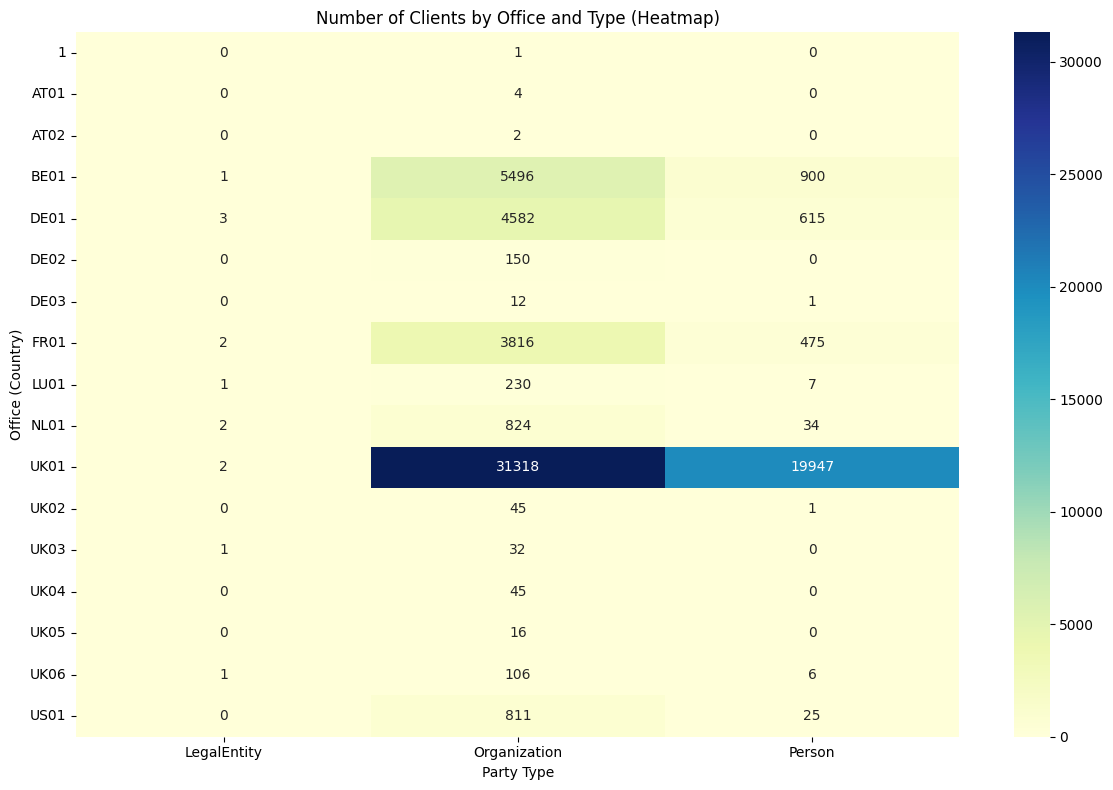

In [10]:
# Your existing code
clients_df["Country"] = clients_df["ClientId"].str[:4]
country_counts = clients_df.groupby(["Country", "PartyType"]).size().unstack()

# Fill NaN values with zeros
country_counts = country_counts.fillna(0)

# Convert DataFrame to integers
country_counts = country_counts.astype(int)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(country_counts, annot=True, fmt="d", cmap="YlGnBu")

# Set the chart properties
plt.title("Number of Clients by Office and Type (Heatmap)")
plt.xlabel("Party Type")
plt.ylabel("Office (Country)")

# Save the plot
plt.tight_layout()
plt.savefig("0.1.Number of Clients by Office and Type (Heatmap).png", dpi=300)

# Show the plot
plt.show()

### 3.3.2 Client Status

In [11]:
# Count number of clients by their office and current status
status_counts = clients_df.groupby(["Country","Status"]).size().unstack()

print(status_counts)

Status    Closed    Hold     Open  Pending   Stop
Country                                          
1            NaN     NaN      NaN      1.0    NaN
AT01         NaN     NaN      2.0      2.0    NaN
AT02         NaN     NaN      2.0      NaN    NaN
BE01       362.0   524.0   5135.0    383.0    NaN
DE01      1047.0     4.0   3630.0    109.0  425.0
DE02        13.0     NaN    125.0     12.0    NaN
DE03         NaN     NaN     13.0      NaN    NaN
FR01       146.0     4.0   4038.0    106.0    1.0
LU01         1.0    12.0    207.0     18.0    NaN
NL01       126.0    24.0    705.0      9.0    NaN
UK01     13215.0  2871.0  29685.0   5620.0    9.0
UK02         NaN     NaN     40.0      6.0    NaN
UK03         NaN     NaN     33.0      NaN    NaN
UK04        28.0     NaN     17.0      NaN    NaN
UK05         1.0     NaN     15.0      NaN    NaN
UK06         2.0     5.0     91.0     15.0    NaN
US01        77.0     1.0    731.0     34.0    NaN


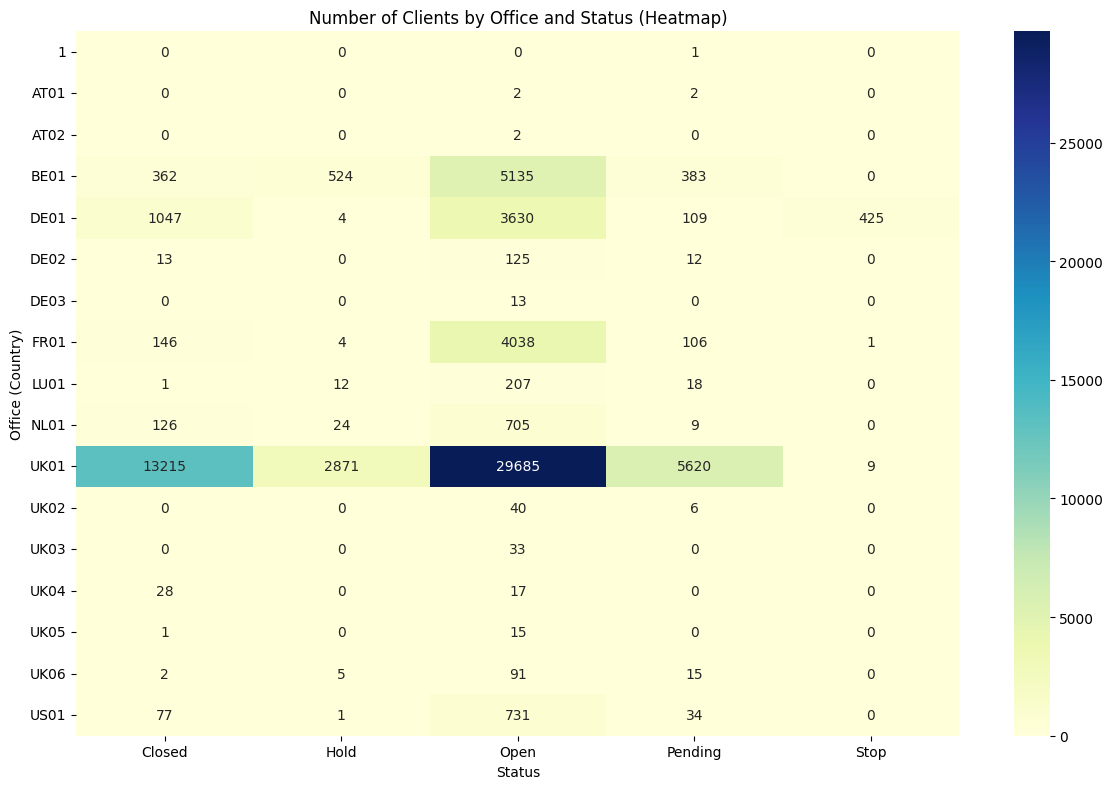

In [12]:
# Your existing code
status_counts = clients_df.groupby(["Country", "Status"]).size().unstack()

# Fill NaN values with zeros
status_counts = status_counts.fillna(0)

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(status_counts, annot=True, fmt="g", cmap="YlGnBu")

# Set the chart properties
plt.title("Number of Clients by Office and Status (Heatmap)")
plt.xlabel("Status")
plt.ylabel("Office (Country)")

# Save the plot
plt.tight_layout()
plt.savefig("0.2.Number of Clients by Office and Status (Heatmap).png", dpi=300)

# Show the plot
plt.tight_layout()
plt.show()


### 3.3.3 Payment Terms

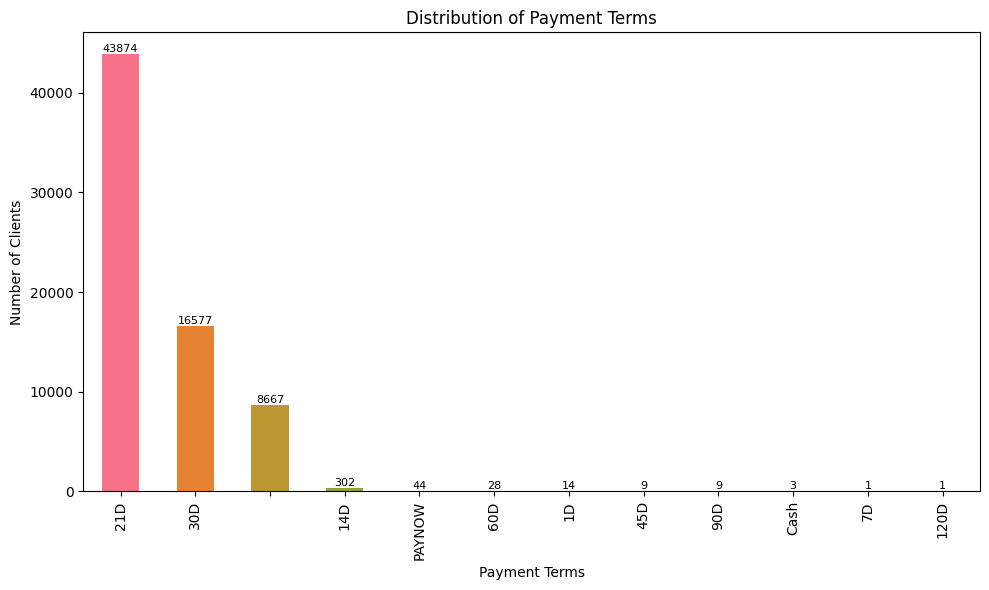

In [13]:
# Your existing code
value_counts = clients_df["PaymentTerms"].value_counts()

# Set a custom color palette
custom_palette = sns.color_palette("husl", len(value_counts))

# Create a bar chart
plt.figure(figsize=(10, 6))
value_counts.plot(kind='bar', color=custom_palette)

# Set the chart properties
plt.title("Distribution of Payment Terms")
plt.xlabel("Payment Terms")
plt.ylabel("Number of Clients")

# Add data labels to each bar
for i, v in enumerate(value_counts):
    plt.text(i, v, str(v), ha='center', va='bottom', fontsize=8)

# Save the plot
plt.tight_layout()
plt.savefig("0.3.Distribution of Payment Terms.png", dpi=300)

# Show the plot
plt.tight_layout()
plt.show()

### 3.3.4 Client years

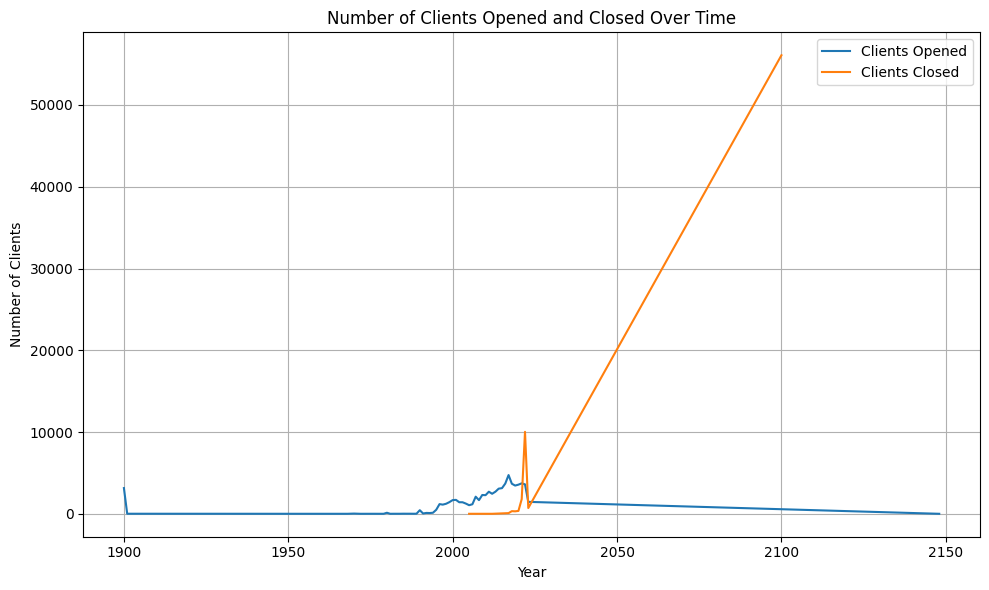

In [14]:
# Make a copy of the DataFrame
clients_df_copy = clients_df.copy()

# Parse dates to datetime type if they are not already
clients_df_copy['DateOpened'] = pd.to_datetime(clients_df_copy['DateOpened'])
clients_df_copy['DateClosed'] = pd.to_datetime(clients_df_copy['DateClosed'])

# Extract year from date
clients_df_copy['YearOpened'] = clients_df_copy['DateOpened'].dt.year

# Replace '1900-01-01 12:00:00' in 'DateClosed' with '2100-01-01 12:00:00' to symbolize open accounts
clients_df_copy.loc[clients_df_copy['DateClosed'] == '1900-01-01 12:00:00', 'DateClosed'] = '2100-01-01 12:00:00'

# Extract year from date
clients_df_copy['YearClosed'] = clients_df_copy['DateClosed'].dt.year

# Count the number of clients opened or closed per year
clients_opened = clients_df_copy['YearOpened'].value_counts().sort_index()
clients_closed = clients_df_copy['YearClosed'].value_counts().sort_index()

# Plotting the data
plt.figure(figsize=(10, 6))
plt.plot(clients_opened, label='Clients Opened')
plt.plot(clients_closed, label='Clients Closed')
plt.xlabel('Year')
plt.ylabel('Number of Clients')
plt.title('Number of Clients Opened and Closed Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.tight_layout()
plt.savefig("0.4.Number of Clients Opened and Closed Over Time.png", dpi=300)

plt.show()

# 4. dbo.Matters

## 4.1 Fetch Table

In [15]:
# Execute the SELECT query
table_name = 'dbo.Matters'  # Replace with the actual table name
query = f'SELECT * FROM {table_name}'

# Fetch all rows from the result set
matters_df = pd.read_sql(query, conn) 

C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1234159026.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  matters_df = pd.read_sql(query, conn)


## 4.2 Data Cleaning

### 4.2.1 Table overview

In [16]:
matters_df

,MatterId,ClientId,MatterDescription,MatterOpenDate,MatterClosedDate,MatterStatus,MatterPartner,Department,ExternalModifiedDate,MDDModifiedDate,MatterFeeEarner,DimensionDisplayValue,DataAreaId,MatterType,WorkType,CostCenter,IsActivityRequiredForHourTransaction,ProjectContractID
0,UK01-000009.00007,UK01-000009,Ministry of Justice: HMPS,2009-11-05 12:00:00,2010-08-02 12:00:00,Completed,DVG,5000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,DVG,101-5000---,uk01,Internal,999,101,None,None
1,UK01-000009.00008,UK01-000009,Nuclear Decommissioning Authority panel appointm,2009-12-10 12:00:00,2010-08-02 12:00:00,Completed,DVG,5000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,DVG,101-5000---,uk01,Internal,999,101,None,None
2,UK01-000009.00009,UK01-000009,Nursing and Midwifery Council panel appointment,2009-12-09 12:00:00,2014-11-28 12:00:00,Completed,MZT,5000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,MZT,101-5000---,uk01,Internal,999,101,None,None
3,UK01-000009.00010,UK01-000009,The Office of the Chief Fire and Rescue Adviser,2010-01-19 12:00:00,2014-11-28 12:00:00,Completed,NRP,3000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,NRP,101-3000---,uk01,Internal,999,101,None,None
4,UK01-000009.00011,UK01-000009,GSCC drafting appointment,2010-01-20 12:00:00,2014-11-28 12:00:00,Completed,MLS,5000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,MLS,101-5000---,uk01,Internal,999,101,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389112,UK01-060746.00001,UK01-060746,Regulatory advice,2014-04-14 12:00:00,2021-07-16 12:00:00,Completed,NPT,1040,2021-07-16 15:25:11.110,2021-07-16 15:25:12.440,NPT,-101-1040--,uk01,TimeMaterial,206,101,None,None
389113,UK01-060747.00001,UK01-060747,Project Helium,2015-07-19 12:00:00,2016-01-19 12:00:00,Completed,RLB,4000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,RLB,101-4000---,uk01,TimeMaterial,405,101,None,None
389114,UK01-060748.00001,UK01-060748,Tier 2 (ICT) Visa Applicaton - Brian Carlton,2015-07-14 12:00:00,2018-07-25 12:00:00,Completed,ACC,3100,2018-07-25 11:25:10.420,2018-07-25 11:25:11.293,GM3,101-3100---,uk01,TimeMaterial,338,101,None,None
389115,UK01-060748.00002,UK01-060748,Immigration Advice,2015-07-07 12:00:00,2018-07-25 12:00:00,Completed,ACC,3100,2018-07-25 11:25:10.420,2018-07-25 11:25:11.293,GM3,101-3100---,uk01,TimeMaterial,338,101,None,None


### 4.2.2 Check for Missing Values

In [17]:
# Check both for NA values and empty string for each column
missing_values = matters_df.isnull().sum() + (matters_df =='').sum()

#print result
print(missing_values)

MatterId                                     1
ClientId                                    17
MatterDescription                            1
MatterOpenDate                               0
MatterClosedDate                             0
MatterStatus                                 0
MatterPartner                                1
Department                                   0
ExternalModifiedDate                         0
MDDModifiedDate                              0
MatterFeeEarner                              3
DimensionDisplayValue                       49
DataAreaId                                   0
MatterType                                   0
WorkType                                     6
CostCenter                                   0
IsActivityRequiredForHourTransaction    259915
ProjectContractID                       263383
dtype: int64


### 4.2.3 Check for Duplicated Values

In [18]:
# Check for duplicate MatterId
duplicate_matter_ids = matters_df[matters_df.duplicated(subset='MatterId')]

# Check if there are any duplicate MatterId
if duplicate_matter_ids.empty:
    print("No duplicate MatterId found.")
else:
    print("Duplicate MatterId found:\n")
    print(duplicate_matter_ids)

No duplicate MatterId found.


### 4.2.4 Check for ongoing Matters

In [19]:
# Filter the DataFrame where the end date is "1900-01-01 12:00:00"
filtered_df = matters_df[matters_df["MatterClosedDate"] == pd.Timestamp("1900-01-01 12:00:00")]

# Display the filtered DataFrame
filtered_df

,MatterId,ClientId,MatterDescription,MatterOpenDate,MatterClosedDate,MatterStatus,MatterPartner,Department,ExternalModifiedDate,MDDModifiedDate,MatterFeeEarner,DimensionDisplayValue,DataAreaId,MatterType,WorkType,CostCenter,IsActivityRequiredForHourTransaction,ProjectContractID
71,UK01-038959.00048,UK01-038959,Assignment of Trade Marks from UK PaymentsAdmi...,2014-04-10 12:00:00,1900-01-01 12:00:00,InProcess,HLS,2200,2019-08-19 12:10:28.110,2019-08-19 12:10:29.093,JA3,-101-2200--,uk01,TimeMaterial,221,101,No,UK01-MC-04587
73,UK01-038959.00050,UK01-038959,BACS Payment Schemes Limited Trade MarkARUCS i...,2014-07-10 12:00:00,1900-01-01 12:00:00,InProcess,HLS,2200,2019-08-19 12:10:28.110,2019-08-19 12:10:29.093,JA3,-101-2200--,uk01,TimeMaterial,220,101,No,UK01-MC-04587
80,UK01-038959.00057,UK01-038959,Opposition against Trade Mark Application No.1...,2015-01-23 12:00:00,1900-01-01 12:00:00,InProcess,HLS,2200,2019-08-19 12:10:28.110,2019-08-19 12:10:29.093,JA3,-101-2200--,uk01,TimeMaterial,223,101,No,UK01-MC-04587
81,UK01-038959.00058,UK01-038959,BACS Payment Schemes Limited TradeMark BACSAFE...,2015-03-03 12:00:00,1900-01-01 12:00:00,InProcess,HLS,2200,2019-08-19 12:10:28.110,2019-08-19 12:10:29.093,JA3,-101-2200--,uk01,TimeMaterial,222,101,No,UK01-MC-04587
82,UK01-038959.00059,UK01-038959,BACS Payment Schemes Limited Trade MarkBACS AP...,2015-04-08 12:00:00,1900-01-01 12:00:00,InProcess,HLS,2200,2019-08-19 12:10:28.110,2019-08-19 12:10:29.093,JA3,-101-2200--,uk01,TimeMaterial,222,101,No,UK01-MC-04587
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
389064,UK01-060734.00002,UK01-060734,Great Wall Motor Company Limited renewal andch...,2015-10-13 12:00:00,1900-01-01 12:00:00,InProcess,HJG,2200,2022-12-07 11:40:07.463,2022-12-07 11:40:08.997,FP5,-101-2200--,uk01,TimeMaterial,222,101,No,UK01-MC1-031965
389065,UK01-060734.00003,UK01-060734,"Deli Group Co., Ltd. Trade Mark Application No...",2015-10-23 12:00:00,1900-01-01 12:00:00,InProcess,HJG,2200,2022-12-07 11:40:07.463,2022-12-07 11:40:08.997,FP5,-101-2200--,uk01,TimeMaterial,220,101,No,UK01-MC1-037842
389069,UK01-060735.00004,UK01-060735,CPD for Dentists Advice,2018-03-19 12:00:00,1900-01-01 12:00:00,InProcess,SLE,5000,2018-03-21 09:55:12.200,2018-03-21 09:55:13.063,AD4,102-5000---,uk01,TimeMaterial,200,102,No,UK01-MC1-011006
389070,UK01-060735.00005,UK01-060735,Sonia Joshi,2018-03-26 12:00:00,1900-01-01 12:00:00,InProcess,AD4,2000,2018-03-27 09:10:09.107,2018-03-27 09:10:09.987,AD4,101-2000---,uk01,TimeMaterial,200,101,No,UK01-MC1-011006


In [20]:
unique_matter_status = filtered_df["MatterStatus"].unique()
unique_matter_status

array(['InProcess', 'Completed', 'User1'], dtype=object)

In [21]:
# Find rows where MatterStatus is 'Completed' in filtered_df
completed_rows = filtered_df[filtered_df["MatterStatus"] == 'Completed']

# Display the rows where MatterStatus is 'Completed'
completed_rows

,MatterId,ClientId,MatterDescription,MatterOpenDate,MatterClosedDate,MatterStatus,MatterPartner,Department,ExternalModifiedDate,MDDModifiedDate,MatterFeeEarner,DimensionDisplayValue,DataAreaId,MatterType,WorkType,CostCenter,IsActivityRequiredForHourTransaction,ProjectContractID
1050,UK01-002676.00000,UK01-002676,Deeds Matter,2002-07-23 12:00:00,1900-01-01 12:00:00,Completed,XXX,9000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,XXX,101-9000---,uk01,Internal,999,101,None,None
6415,UK01-1801416.000000,UK01-1801416,Business Development,2016-05-04 12:00:00,1900-01-01 12:00:00,Completed,HM4,6000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,HM4,103-6000---,uk01,Internal,997,103,None,None
6417,UK01-1801417.000000,UK01-1801417,Business Development,2016-05-04 12:00:00,1900-01-01 12:00:00,Completed,DS4,6000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,DS4,103-6000---,uk01,Internal,997,103,None,None
6418,UK01-1801418.000000,UK01-1801418,Business Development,2016-05-04 12:00:00,1900-01-01 12:00:00,Completed,DS4,6000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,DS4,103-6000---,uk01,Internal,997,103,None,None
6419,UK01-1801419.000000,UK01-1801419,Business Development,2016-05-06 12:00:00,1900-01-01 12:00:00,Completed,ML2,4000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,ML2,103-4000---,uk01,Internal,997,103,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
388812,UK01-1801411.000000,UK01-1801411,Business Development,2016-04-28 12:00:00,1900-01-01 12:00:00,Completed,HM4,6000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,HM4,103-6000---,uk01,Internal,997,103,None,None
388817,UK01-1801413.000000,UK01-1801413,Business Development,2016-04-29 12:00:00,1900-01-01 12:00:00,Completed,EC3,3400,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,EC3,103-3400---,uk01,Internal,997,103,None,None
388819,UK01-1801414.000000,UK01-1801414,Business Development,2016-05-03 12:00:00,1900-01-01 12:00:00,Completed,JH14,6000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,JH14,103-6000---,uk01,Internal,997,103,None,None
388838,UK01-1801415.000000,UK01-1801415,Business Development,2016-05-03 12:00:00,1900-01-01 12:00:00,Completed,SS10,4000,2017-06-18 17:36:29.853,2017-06-18 17:36:35.210,SS10,103-4000---,uk01,Internal,997,103,None,None


## 4.3 Exploratory Data Analysis

### 4.3.1 Distribution of Matter Status

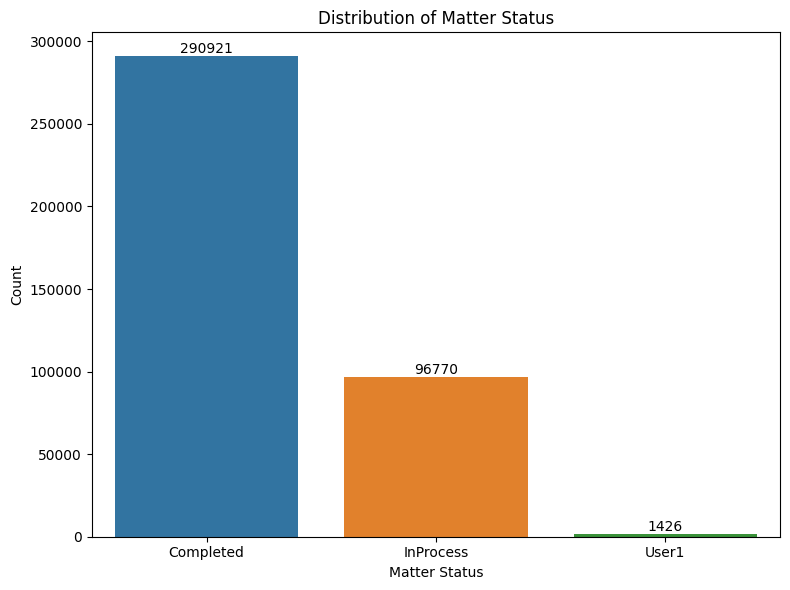

In [22]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=matters_df, x='MatterStatus')

# Add count labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.xlabel('Matter Status')
plt.ylabel('Count')
plt.title('Distribution of Matter Status')

# Save the plot
plt.tight_layout()
plt.savefig("0.5.Distribution of Matter Status(unclean).png", dpi=300)

plt.show()


In [23]:
user1_rows = matters_df[matters_df['MatterStatus'] == 'User1']
user1_rows

,MatterId,ClientId,MatterDescription,MatterOpenDate,MatterClosedDate,MatterStatus,MatterPartner,Department,ExternalModifiedDate,MDDModifiedDate,MatterFeeEarner,DimensionDisplayValue,DataAreaId,MatterType,WorkType,CostCenter,IsActivityRequiredForHourTransaction,ProjectContractID
4583,DE01-2000947.00002,DE01-2000947,DIS-SV-2022-00729 - ConSigma ./. Fr. Jamin-Kel...,2023-02-10 12:00:00,1900-01-01 12:00:00,User1,PHD,6000,2023-02-10 08:40:07.087,2023-02-10 08:40:07.413,PHD,-131-6000-2020-SYR,de01,TimeMaterial,101,131,No,DE01-MC-00903
4587,DE01-2000949.00004,DE01-2000949,"Verteidigung im Verfahren StA Münster, Az. 45 ...",2021-08-30 12:00:00,1900-01-01 12:00:00,User1,MKE,3400,2023-02-24 09:55:11.097,2023-02-24 09:55:12.970,MKE,-132-3400-2022-MKE,de01,TimeMaterial,702,132,No,DE01-MC-00908
4597,DE01-2000957.00002,DE01-2000957,GAE001/0093 - CARRICKALLEN WIND LIMITED – Germ...,2020-05-22 12:00:00,1900-01-01 12:00:00,User1,PHA,3010,2020-06-29 18:10:14.653,2020-06-29 18:10:15.777,PHA,-132-3010-2021-PHA,de01,TimeMaterial,338,132,None,None
4603,DE01-2000968.00001,DE01-2000968,Regulatorische Beratung,2020-04-20 12:00:00,1900-01-01 12:00:00,User1,SBA,3000,2020-06-29 18:10:14.653,2020-06-29 18:10:15.777,SBA,-130-3000-2020-BA,de01,TimeMaterial,200,130,None,None
4643,DE01-2000993.00007,DE01-2000993,Egon-Erwin-Kisch-Str. 80,2023-05-24 12:00:00,1900-01-01 12:00:00,User1,PST,4030,2023-05-24 12:10:05.140,2023-05-24 12:10:06.687,PST,-130-4030--PST---,de01,TimeMaterial,405,130,No,DE01-MC-00939
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
385953,UK01-1800964.000005,UK01-1800964,"Sale of Land at Park Lane, Wednesbury to Walsa...",2015-10-15 12:00:00,1900-01-01 12:00:00,User1,SS10,4100,2019-09-13 15:55:10.580,2019-09-13 15:55:11.627,EA1,-103-4100--,uk01,TimeMaterial,409,103,None,None
386350,UK01-1801005.000011,UK01-1801005,"24 High Street, Cradley Heath",2019-06-03 12:00:00,1900-01-01 12:00:00,User1,NP3,4030,2019-06-03 15:25:12.187,2019-06-03 15:25:13.170,EC15,-103-4030--,uk01,TimeMaterial,411,103,None,None
386910,UK01-1801100.000008,UK01-1801100,"Potential PI Claim re: Bournville, Beaufort an...",2018-06-19 12:00:00,1900-01-01 12:00:00,User1,MW13,4030,2018-06-19 16:10:13.600,2018-06-19 16:10:14.443,HA2,103-4030---,uk01,TimeMaterial,400,103,None,None
387832,UK01-060455.00005,UK01-060455,P/O 36 Freshwater View,2017-03-03 12:00:00,1900-01-01 12:00:00,User1,MPD,4000,2018-02-26 09:25:11.167,2018-02-26 09:25:11.927,MPD,102-4000---,uk01,TimeMaterial,405,102,None,None


In [24]:
unique_years = user1_rows['MatterClosedDate'].dt.year.unique()
print(unique_years)

[1900 2021 2020 2017 2019 2022 2016]


In [25]:
# Create a mask to identify rows with "User1" status
mask = matters_df['MatterStatus'] == 'User1'

# Delete rows with "User1" status
matters_df = matters_df[~mask]

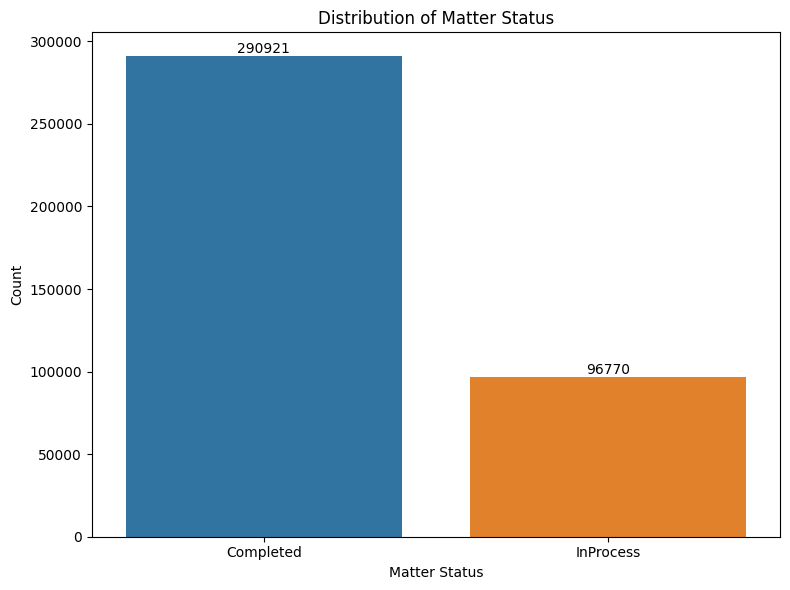

In [26]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(data=matters_df, x='MatterStatus')

# Add count labels to the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()), ha = 'center', va = 'center', xytext = (0, 5), textcoords = 'offset points')

plt.xlabel('Matter Status')
plt.ylabel('Count')
plt.title('Distribution of Matter Status')

# Save the plot
plt.tight_layout()
plt.savefig("0.6.Distribution of Matter Status(clean).png", dpi=300)

plt.show()

### 4.3.2 Matters opened over time

In [27]:
# Extract the year from the MatterOpenDate column
matters_df['Year'] = pd.to_datetime(matters_df['MatterOpenDate']).dt.year

# Count the number of matters opened in each year
counts = matters_df['Year'].value_counts().sort_index()

print(counts)

Year
1900      129
1939        1
1940        1
1965        1
1968        1
1969        1
1970       57
1972        1
1973        3
1974        4
1975        3
1976        4
1977        7
1978        2
1979        3
1980      948
1981        3
1982        6
1983        6
1984        8
1985        9
1986       16
1987       16
1988       51
1989     1296
1990     1360
1991      734
1992     1463
1993     1590
1994     2536
1995     4304
1996     5065
1997     5367
1998     5969
1999     9932
2000     9330
2001    10221
2002    10702
2003     9483
2004     9697
2005    10436
2006    10803
2007    14529
2008    12113
2009    10248
2010    11446
2011    15778
2012    12263
2013    14887
2014    15192
2015    15268
2016    16721
2017    24854
2018    21741
2019    21914
2020    19049
2021    21417
2022    20189
2023     8513
Name: count, dtype: int64


C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\3831164701.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['Year'] = pd.to_datetime(matters_df['MatterOpenDate']).dt.year


C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\3478533755.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['MatterOpenDate'] = pd.to_datetime(matters_df['MatterOpenDate'])
C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\3478533755.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['YearMonth'] = matters_df['MatterOpenDate'].dt.to_period('M')


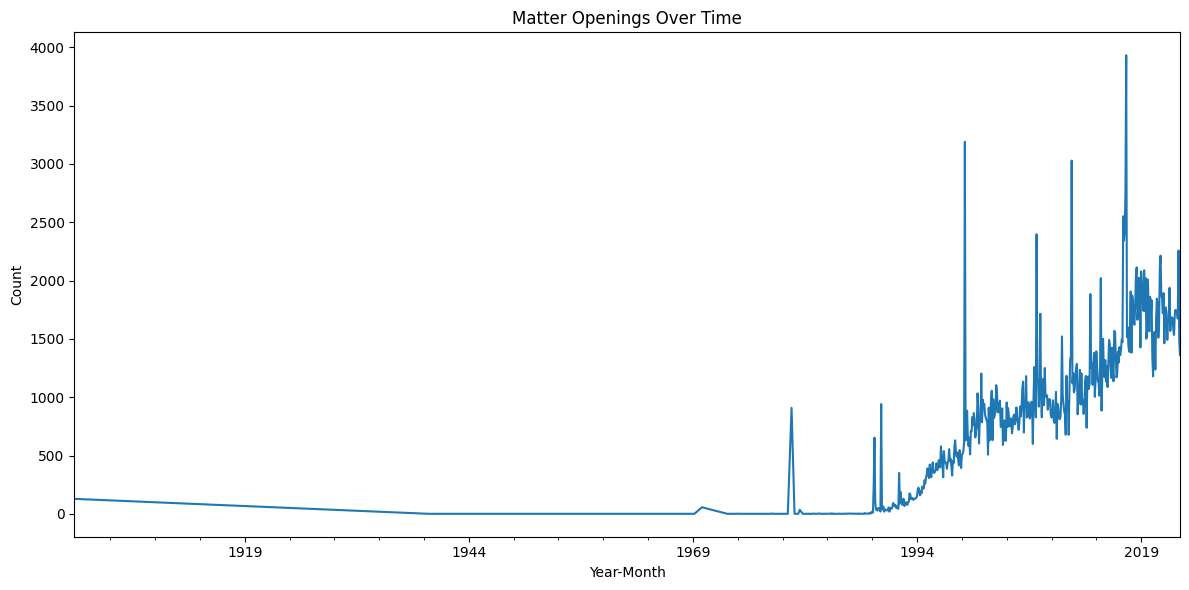

In [28]:
matters_df['MatterOpenDate'] = pd.to_datetime(matters_df['MatterOpenDate'])
matters_df['YearMonth'] = matters_df['MatterOpenDate'].dt.to_period('M')

counts = matters_df['YearMonth'].value_counts().sort_index()

plt.figure(figsize=(12, 6))
counts.plot(kind='line')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Matter Openings Over Time')

# Save the plot
plt.tight_layout()
plt.savefig("0.7.Matter Openings Over Time.png", dpi=300)

plt.show()

# 5. dbo.MatterWorkType

## 5.1 Fetch table

In [29]:
# Execute the SELECT query
table_name = 'dbo.MatterWorkType'  # Replace with the actual table name
query = f'SELECT * FROM {table_name}'

# Fetch all rows from the result set
matters_type_df = pd.read_sql(query, conn) 

C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\4210245331.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  matters_type_df = pd.read_sql(query, conn)


## 5.2 Data Cleaning

### 5.2.1 Table Overview

In [30]:
matters_type_df

,DataAreaID,Identification,Description
0,nl01,10.0,Media - Production
1,nl01,100.0,Litigation - Commercial
2,nl01,101.0,Litigation - Other
3,nl01,102.0,Litigation - Regulatory - Professional
4,nl01,103.0,Litigation - Travel
...,...,...,...
1536,lu01,982.0,Non-Billable - Regulatory
1537,lu01,983.0,Non-Billable - Complaint
1538,lu01,984.0,Non-Billable - Notification
1539,lu01,996.0,Secondment


### 5.2.2 Check of Missing Values

In [31]:
# Check both for NA values and empty string for each column
missing_values = matters_type_df.isnull().sum() + (matters_type_df =='').sum()

#print result
print(missing_values)

DataAreaID        1
Identification    1
Description       1
dtype: int64


In [32]:
counts = matters_type_df['DataAreaID'].value_counts()
print(counts)


DataAreaID
uk01    120
uk05    110
lu01    108
uk03    108
uk02    108
uk04    102
nl01     98
us01     98
be01     98
de01     98
fr01     98
de02     98
de03     98
at01     98
at02     98
uk06      2
Name: count, dtype: int64


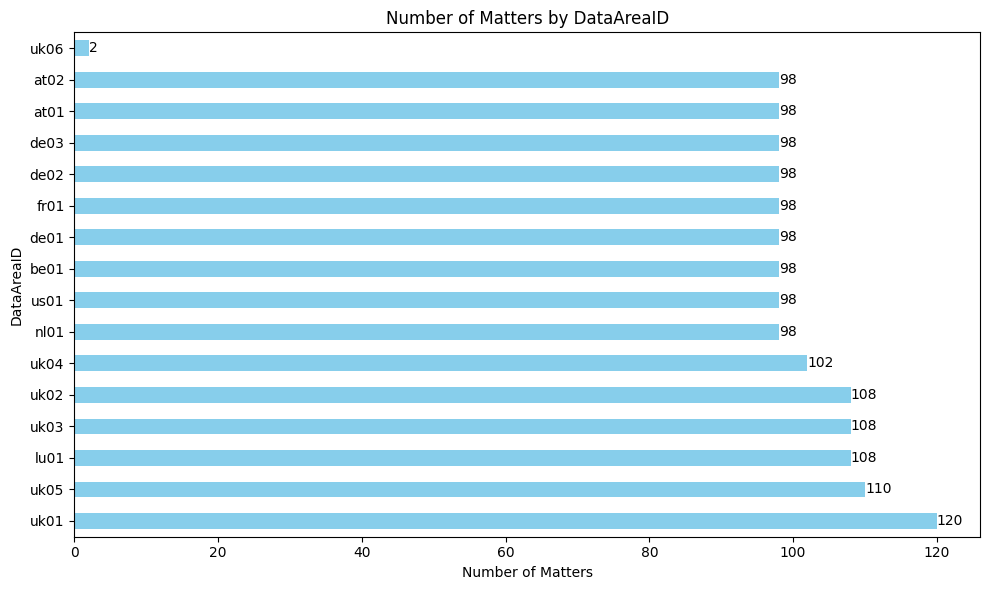

In [33]:
# Your existing code
counts = matters_type_df['DataAreaID'].value_counts()

# Create a horizontal bar chart
plt.figure(figsize=(10, 6))
bars = counts.plot(kind='barh', color='skyblue')

# Set the chart properties
plt.title("Number of Matters by DataAreaID")
plt.xlabel("Number of Matters")
plt.ylabel("DataAreaID")

# Annotate the bars with their respective values
for b in bars.patches:
    plt.text(b.get_width(), b.get_y() + b.get_height() / 2,
             '{:1.0f}'.format(b.get_width()), 
             ha='left', va='center')

# Save the plot
plt.tight_layout()
plt.savefig("0.8.Number of Matters by DataAreaID.png", dpi=300)

# Show the plot
plt.show()


# 6. dbo.iManageDocumentCounts

In [34]:
# Execute the SELECT query
table_name = 'dbo.iManageDocumentCounts'  # Replace with the actual table name
query = f'SELECT * FROM {table_name}'

# Fetch all rows from the result set
imanage_df = pd.read_sql(query, conn) 

C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1010054259.py:6: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  imanage_df = pd.read_sql(query, conn)


In [35]:
imanage_df

,Client,Matter,TotalDocumentsCreated,E-MAIL,DOC,BILL,LETTER,ATTEND,SPR,FORM,MEMO,PROCEEDING,MEDIA,PRESENTATION,BIBLE,PUBLICATION,BUS,APPR,TENDER,POLICY
0,30615,00244,8,1,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,UK01-2008112,00001,4543,3604,640,3,154,126,1,7,2,4,0,0,0,0,0,0,0,0
2,FR01-045363,00024,391,352,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,UK01-062626,00065,232,116,38,75,3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,UK01-065733,01521,40,9,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313978,UK01-065733,02975,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313979,UK01-043851,00140,21,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313980,UK01-043565,00293,34,26,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313981,27264,00450,12,0,2,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0


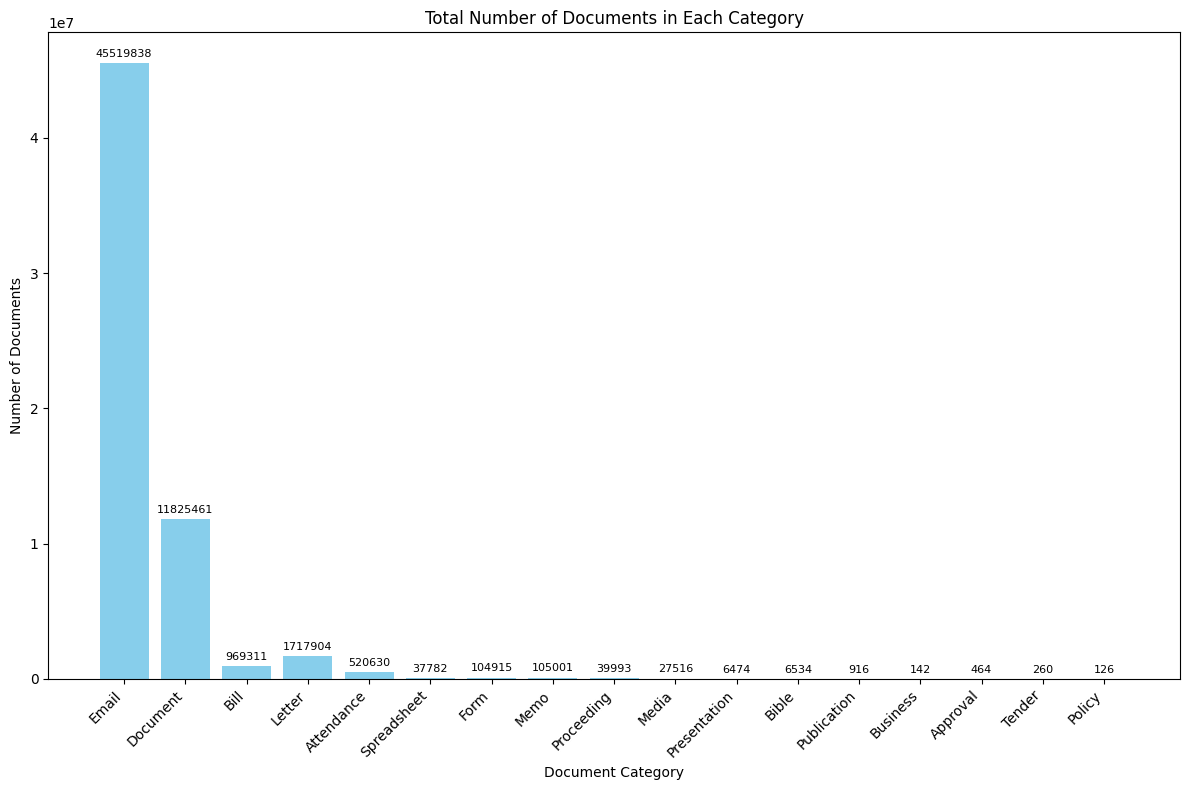

In [36]:
# Your existing code
category_columns = ['E-MAIL', 'DOC', 'BILL', 'LETTER', 'ATTEND', 'SPR', 'FORM', 'MEMO', 'PROCEEDING', 'MEDIA', 'PRESENTATION', 'BIBLE', 'PUBLICATION', 'BUS', 'APPR', 'TENDER', 'POLICY']
category_labels = ['Email', 'Document', 'Bill', 'Letter', 'Attendance', 'Spreadsheet', 'Form', 'Memo', 'Proceeding', 'Media', 'Presentation', 'Bible', 'Publication', 'Business', 'Approval', 'Tender', 'Policy']

# Calculate the total number of documents for each category
total_documents_per_category = imanage_df[category_columns].sum()

# Create a bar chart
plt.figure(figsize=(12, 8))
bars = plt.bar(range(len(total_documents_per_category)), total_documents_per_category, tick_label=category_labels, color='skyblue')

# Set the chart properties
plt.title("Total Number of Documents in Each Category")
plt.xlabel("Document Category")
plt.ylabel("Number of Documents")
plt.xticks(rotation=45, ha='right')

# Show the number of documents on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{int(height)}', xy=(bar.get_x() + bar.get_width() / 2, height), xytext=(0, 3), 
                 textcoords="offset points", ha='center', va='bottom', fontsize=8)

# Save the plot
plt.tight_layout()
plt.savefig("0.9.Total Number of Documents in Each Category.png", dpi=300)

# Show the plot
plt.show()

# 7. dbo.vw_DEBillPeriodFactsStaging

2017 was the year EverGreen was implemented

In [37]:
# Specify the table name
table_name = 'dbo.vw_DEBillPeriodFactsStaging'

# Define the columns you want to select
columns = ['ACCOUNTNUM', 'BILLPERIOD', 'FEESBILLEDGBP', 'MATTERDATAAREA', 'PROJID', 'HOURSBILLED']

# Construct the SQL query
query = f'SELECT {", ".join(columns)} FROM {table_name}'

# Fetch the rows from the result set
bill_period_df = pd.read_sql(query, conn)


C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\3819875963.py:11: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  bill_period_df = pd.read_sql(query, conn)


In [38]:
bill_period_df

,ACCOUNTNUM,BILLPERIOD,FEESBILLEDGBP,MATTERDATAAREA,PROJID,HOURSBILLED
0,DE01-063413,2018-12-01,1797.623541,de01,DE01-063413.00001,8.0
1,DE01-063413,2019-02-01,1317.675000,de01,DE01-063413.00001,6.0
2,DE01-063413,2019-06-01,1344.134198,de01,DE01-063413.00001,6.0
3,DE01-063413,2019-09-01,1331.640670,de01,DE01-063413.00001,6.0
4,DE01-063413,2019-11-01,1317.675000,de01,DE01-063413.00001,6.0
...,...,...,...,...,...,...
1080258,DE01-050001,2022-10-01,-418.314438,de01,DE01-050001.01159,-1.7
1080259,DE01-050001,2022-10-01,418.314438,de01,DE01-050001.01159,1.7
1080260,DE01-050001,2022-10-01,195.193600,de01,DE01-050001.01159,0.8
1080261,DE01-050001,2022-12-01,74.248236,de01,DE01-050001.01159,0.3


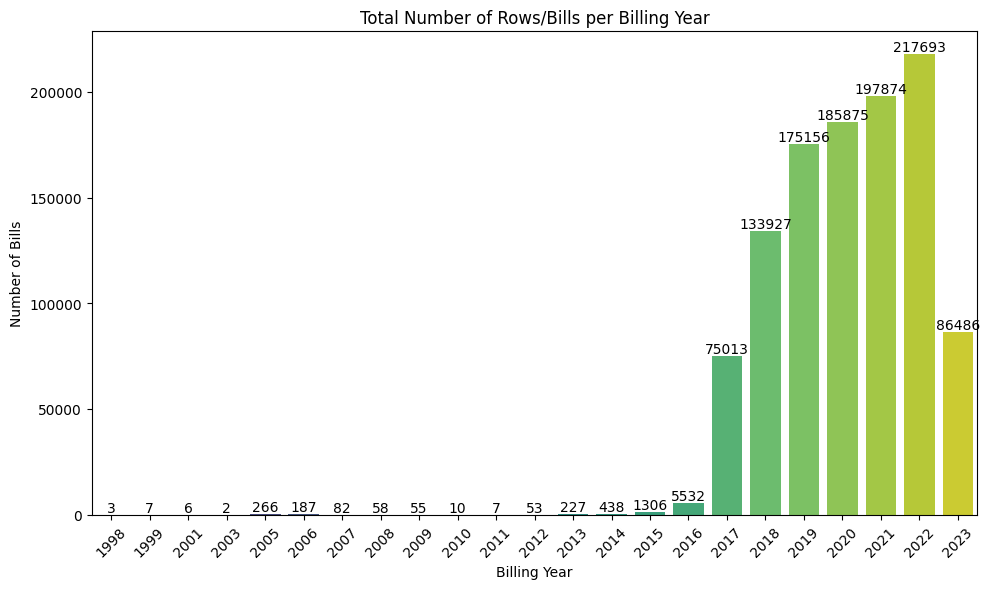

In [39]:
# Assuming bill_period_df is your DataFrame containing the data
# Convert the 'BILLPERIOD' column to datetime type
bill_period_df['BILLPERIOD'] = pd.to_datetime(bill_period_df['BILLPERIOD'])

# Extract the billing year from the 'BILLPERIOD' column
bill_period_df['BillingYear'] = bill_period_df['BILLPERIOD'].dt.year

# Group by the billing year and calculate the count of rows/bills in each group
bills_per_year = bill_period_df.groupby('BillingYear').size()

# Reset the index to have 'BillingYear' as a regular column
bills_per_year = bills_per_year.reset_index(name='BillCount')

# Create the bar plot using seaborn
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='BillingYear', y='BillCount', data=bills_per_year, palette='viridis')
plt.xlabel('Billing Year')
plt.ylabel('Number of Bills')
plt.title('Total Number of Rows/Bills per Billing Year')
plt.xticks(rotation=45)
plt.tight_layout()

# Add annotations (numbers on top of the bars)
for index, value in enumerate(bills_per_year['BillCount']):
    ax.text(index, value, str(value), ha='center', va='bottom', fontsize=10)

# Save the plot
plt.tight_layout()
plt.savefig("0.10.Total Number of Rows and Bills per Billing Year.png", dpi=300)

plt.show()

bill_period_df

# 8. Master Table Aggregation

## 8.1 Create Client Bills by combining bill period with clients

In [40]:
# Convert the 'bill_period' column in 'bills_df' dataframe
bill_period_df['BILLPERIOD'] = pd.to_datetime(bill_period_df['BILLPERIOD'])

# Convert the 'open_date' and 'close_date' columns in 'matters_df' dataframe
matters_df['MatterOpenDate'] = pd.to_datetime(matters_df['MatterOpenDate'])
matters_df['MatterClosedDate'] = pd.to_datetime(matters_df['MatterClosedDate'])

C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1762661636.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['MatterOpenDate'] = pd.to_datetime(matters_df['MatterOpenDate'])
C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1762661636.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['MatterClosedDate'] = pd.to_datetime(matters_df['MatterClosedDate'])


In [41]:
# Convert 'DateOpened' and 'DateClosed' columns to datetime type
clients_df['DateOpened'] = pd.to_datetime(clients_df['DateOpened'])
clients_df['DateClosed'] = pd.to_datetime(clients_df['DateClosed'])

# Define the ongoing_date (far future date)
ongoing_date = pd.to_datetime('2100-01-01')

# Modify the 'DateClosed' column based on conditions
mask_open = (clients_df['DateClosed'].dt.year == 1900) & (clients_df['Status'] == 'Open')
mask_closed = (clients_df['DateClosed'].dt.year == 1900) & (clients_df['Status'] != 'Open')

clients_df.loc[mask_open, 'DateClosed'] = ongoing_date
clients_df.loc[mask_closed, 'DateClosed'] = clients_df.loc[mask_closed, 'DateOpened'].apply(lambda x: pd.to_datetime(str(x.year) + '-12-31'))

In [42]:
# Convert 'MatterOpenDate' and 'MatterClosedDate' columns to datetime type
matters_df['MatterOpenDate'] = pd.to_datetime(matters_df['MatterOpenDate'])
matters_df['MatterClosedDate'] = pd.to_datetime(matters_df['MatterClosedDate'])

# Define the ongoing_date (far future date)
ongoing_date = pd.to_datetime('2100-01-01')

# Modify the 'MatterClosedDate' column based on conditions
mask_completed = (matters_df['MatterClosedDate'].dt.year == 1900) & (matters_df['MatterStatus'] == 'Completed')
mask_inprocess = (matters_df['MatterClosedDate'].dt.year == 1900) & (matters_df['MatterStatus'] == 'InProcess')

# Set 'MatterClosedDate' to ongoing_date where MatterStatus is 'InProcess'
matters_df.loc[mask_inprocess, 'MatterClosedDate'] = ongoing_date

# Set 'MatterClosedDate' to the end of the year of 'MatterOpenDate' where MatterStatus is 'Completed'
matters_df.loc[mask_completed, 'MatterClosedDate'] = matters_df.loc[mask_completed, 'MatterOpenDate'] + pd.offsets.YearEnd(0)


C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1849893959.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['MatterOpenDate'] = pd.to_datetime(matters_df['MatterOpenDate'])
C:\Users\RO10\AppData\Local\Temp\3\ipykernel_1600\1849893959.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  matters_df['MatterClosedDate'] = pd.to_datetime(matters_df['MatterClosedDate'])


In [43]:
# Merge on 'ACCOUNTNUM' from bill_period_df and 'ClientId' from clients_df
clients_bills = pd.merge(bill_period_df, clients_df, left_on='ACCOUNTNUM', right_on='ClientId')

In [44]:
clients_bills

,ACCOUNTNUM,BILLPERIOD,FEESBILLEDGBP,MATTERDATAAREA,PROJID,HOURSBILLED,BillingYear,ClientId,PartyNumber,ClientName,MDDModifiedDate,DateOpened,DateClosed,PrimaryContactPhone,EmployeeResponsibleNumber,Status,PaymentTerms,PartyType,LanguageId,Country
0,DE01-063413,2018-12-01,1797.623541,de01,DE01-063413.00001,8.0,2018,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01
1,DE01-063413,2019-02-01,1317.675000,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01
2,DE01-063413,2019-06-01,1344.134198,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01
3,DE01-063413,2019-09-01,1331.640670,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01
4,DE01-063413,2019-11-01,1317.675000,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080258,DE01-2002305,2022-09-01,117.117117,de01,DE01-2002305.00001,0.4,2022,DE01-2002305,000236680,SCHÖNING STEUERBERATUNGSGESELLSCHAFT mbH,2022-09-22 19:08:51.097,2022-06-13 12:00:00,2100-01-01,,DEHI,Open,30D,Organization,en-GB,DE01
1080259,DE01-2002305,2022-12-01,315.996959,de01,DE01-2002305.00001,1.1,2022,DE01-2002305,000236680,SCHÖNING STEUERBERATUNGSGESELLSCHAFT mbH,2022-09-22 19:08:51.097,2022-06-13 12:00:00,2100-01-01,,DEHI,Open,30D,Organization,en-GB,DE01
1080260,DE01-2002600,2022-12-01,1144.660313,de01,DE01-2002600.00001,3.7,2022,DE01-2002600,000240387,Hotel und Restaurant Zur alten Muhle GmbH,2023-02-15 11:09:22.693,2022-11-22 12:00:00,2100-01-01,,DEHI,Open,30D,Organization,de,DE01
1080261,DE01-2002600,2023-01-01,3973.072859,de01,DE01-2002600.00001,12.9,2023,DE01-2002600,000240387,Hotel und Restaurant Zur alten Muhle GmbH,2023-02-15 11:09:22.693,2022-11-22 12:00:00,2100-01-01,,DEHI,Open,30D,Organization,de,DE01


## 8.2 Create clients_bills_matters by combining clients_bills with matters

In [45]:
clients_bills_matters = pd.merge(clients_bills, matters_df, left_on='PROJID', right_on='MatterId')

In [46]:
clients_bills_matters

,ACCOUNTNUM,BILLPERIOD,FEESBILLEDGBP,MATTERDATAAREA,PROJID,HOURSBILLED,BillingYear,ClientId_x,PartyNumber,ClientName,MDDModifiedDate_x,DateOpened,DateClosed,PrimaryContactPhone,EmployeeResponsibleNumber,Status,PaymentTerms,PartyType,LanguageId,Country,MatterId,ClientId_y,MatterDescription,MatterOpenDate,MatterClosedDate,MatterStatus,MatterPartner,Department,ExternalModifiedDate,MDDModifiedDate_y,MatterFeeEarner,DimensionDisplayValue,DataAreaId,MatterType,WorkType,CostCenter,IsActivityRequiredForHourTransaction,ProjectContractID,Year,YearMonth
0,DE01-063413,2018-12-01,1797.623541,de01,DE01-063413.00001,8.0,2018,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01,DE01-063413.00001,DE01-063413,EUR 1.500 / Sitzung Kontrollgremium gem. Verei...,2016-09-06 12:00:00,2100-01-01,InProcess,OSU,2200,2022-05-26 14:18:46.190,2022-05-26 14:18:48.580,OSU,-130-2200--,de01,TimeMaterial,997,130,No,DE01-MC-001863,2016,2016-09
1,DE01-063413,2019-02-01,1317.675000,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01,DE01-063413.00001,DE01-063413,EUR 1.500 / Sitzung Kontrollgremium gem. Verei...,2016-09-06 12:00:00,2100-01-01,InProcess,OSU,2200,2022-05-26 14:18:46.190,2022-05-26 14:18:48.580,OSU,-130-2200--,de01,TimeMaterial,997,130,No,DE01-MC-001863,2016,2016-09
2,DE01-063413,2019-06-01,1344.134198,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01,DE01-063413.00001,DE01-063413,EUR 1.500 / Sitzung Kontrollgremium gem. Verei...,2016-09-06 12:00:00,2100-01-01,InProcess,OSU,2200,2022-05-26 14:18:46.190,2022-05-26 14:18:48.580,OSU,-130-2200--,de01,TimeMaterial,997,130,No,DE01-MC-001863,2016,2016-09
3,DE01-063413,2019-09-01,1331.640670,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01,DE01-063413.00001,DE01-063413,EUR 1.500 / Sitzung Kontrollgremium gem. Verei...,2016-09-06 12:00:00,2100-01-01,InProcess,OSU,2200,2022-05-26 14:18:46.190,2022-05-26 14:18:48.580,OSU,-130-2200--,de01,TimeMaterial,997,130,No,DE01-MC-001863,2016,2016-09
4,DE01-063413,2019-11-01,1317.675000,de01,DE01-063413.00001,6.0,2019,DE01-063413,C-DE01-063413,Hamburg Top-Level-Domain GmbH,2022-05-22 19:30:29.280,2016-09-01 12:00:00,2100-01-01,,OSU,Open,30D,Organization,de,DE01,DE01-063413.00001,DE01-063413,EUR 1.500 / Sitzung Kontrollgremium gem. Verei...,2016-09-06 12:00:00,2100-01-01,InProcess,OSU,2200,2022-05-26 14:18:46.190,2022-05-26 14:18:48.580,OSU,-130-2200--,de01,TimeMaterial,997,130,No,DE01-MC-001863,2016,2016-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077367,DE01-2002305,2022-09-01,117.117117,de01,DE01-2002305.00001,0.4,2022,DE01-2002305,000236680,SCHÖNING STEUERBERATUNGSGESELLSCHAFT mbH,2022-09-22 19:08:51.097,2022-06-13 12:00:00,2100-01-01,,DEHI,Open,30D,Organization,en-GB,DE01,DE01-2002305.00001,DE01-2002305,Schöning – Corona,2022-06-14 12:00:00,2100-01-01,InProcess,DEHI,5100,2022-06-14 13:55:08.897,2022-06-14 13:55:10.397,DEHI,-130-5100-2023-DEHI,de01,TimeMaterial,771,130,No,DE01-MC-02215,2022,2022-06
1077368,DE01-2002305,2022-12-01,315.996959,de01,DE01-2002305.00001,1.1,2022,DE01-2002305,000236680,SCHÖNING STEUERBERATUNGSGESELLSCHAFT mbH,2022-09-22 19:08:51.097,2022-06-13 12:00:00,2100-01-01,,DEHI,Open,30D,Organization,en-GB,DE01,DE01-2002305.00001,DE01-2002305,Schöning – Corona,2022-06-14 12:00:00,2100-01-01,InProcess,DEHI,5100,2022-06-14 13:55:08.897,2022-06-14 13:55:10.397,DEHI,-130-5100-2023-DEHI,de01,TimeMaterial,771,130,No,DE01-MC-02215,2022,2022-06
1077369,DE01-2002600,2022-12-

## 8.3 Create Master Table by aggregating client bills matters based on account num and year

In [47]:
# Group data by 'client_id', 'client_name' and 'bill_year', and compute the sum of 'bill_gbp'
clients_bills_matters['bill_year'] = clients_bills_matters['BILLPERIOD'].dt.year
master_table = clients_bills_matters.groupby(['ACCOUNTNUM', 'ClientName', 'bill_year','PartyType'], as_index=False)['FEESBILLEDGBP'].sum()

In [48]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269
...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547
54717,US01-2000539,Buildkite PTY Ltd,2023,Organization,9228.568806
54718,US01-2000540,"ThoughtSpot, Inc.",2023,Organization,2559.910311
54719,US01-2000541,"AH Capital Management, L.L.C.",2023,Organization,545.802977


### 8.3.1 Hours billed

In [49]:
# Convert 'MatterOpenDate' to datetime and create 'bill_year' column
clients_bills_matters['MatterOpenDate'] = pd.to_datetime(clients_bills_matters['MatterOpenDate'])
clients_bills_matters['bill_year'] = clients_bills_matters['MatterOpenDate'].dt.year

# Group by 'ACCOUNTNUM' and 'bill_year', and calculate the sum of 'HOURSBILLED'
billed_hours_df = clients_bills_matters.groupby(['ACCOUNTNUM', 'bill_year'])['HOURSBILLED'].sum().reset_index()

# Merge 'billed_hours_df' with 'master_table'
master_table = pd.merge(master_table, billed_hours_df, on=['ACCOUNTNUM', 'bill_year'], how='left')

# Replace NaNs with 0 in 'HOURSBILLED' column
master_table['HOURSBILLED'] = master_table['HOURSBILLED'].fillna(0)


### 8.3.1 Create number of ongoing matters 

In [50]:
# Create an empty DataFrame to store ongoing matters count
ongoing_matters = pd.DataFrame()

# Get the minimum and maximum year in the data
min_year = min(clients_bills_matters['MatterOpenDate'].dt.year.min(), clients_bills_matters['BILLPERIOD'].dt.year.min())
max_year = max(clients_bills_matters['MatterClosedDate'].dt.year.max(), clients_bills_matters['BILLPERIOD'].dt.year.max())

# For each year, count the number of ongoing matters
for year in range(min_year, max_year + 1):
    ongoing_matters_year = clients_bills_matters[
                                (clients_bills_matters['MatterOpenDate'].dt.year <= year) &
                                ((clients_bills_matters['MatterClosedDate'].dt.year > year) | 
                                (clients_bills_matters['MatterClosedDate'].isnull()))  # Include matters that haven't been closed
                            ].groupby(['ACCOUNTNUM'])['PROJID'].nunique().reset_index()
    ongoing_matters_year['bill_year'] = year
    ongoing_matters = pd.concat([ongoing_matters, ongoing_matters_year], axis=0)

ongoing_matters = ongoing_matters.rename(columns={'PROJID': 'number_of_ongoing_matters'})

# Merge with master_table
master_table = pd.merge(master_table, ongoing_matters, on=['ACCOUNTNUM', 'bill_year'], how='left')

# Fill NaN with 0 and convert to integer
master_table['number_of_ongoing_matters'] = master_table['number_of_ongoing_matters'].fillna(0).astype(int)


In [51]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15
...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1
54717,US01-2000539,Buildkite PTY Ltd,2023,Organization,9228.568806,24.9,1
54718,US01-2000540,"ThoughtSpot, Inc.",2023,Organization,2559.910311,5.8,1
54719,US01-2000541,"AH Capital Management, L.L.C.",2023,Organization,545.802977,6.0,1


### 8.3.2 Create number of new matters opened

In [52]:
# Extract the year from the 'MatterOpenDate'
clients_bills_matters['open_year'] = clients_bills_matters['MatterOpenDate'].dt.year

# Filter rows where the open year equals the bill year, and compute the number of unique matters
newly_opened_matters = clients_bills_matters.groupby(['ACCOUNTNUM', 'open_year'])['PROJID'].nunique().reset_index()

# Rename the column and ensure it's an integer
newly_opened_matters = newly_opened_matters.rename(columns={'PROJID': 'number_of_new_matters', 'open_year': 'bill_year'})
newly_opened_matters['number_of_new_matters'] = newly_opened_matters['number_of_new_matters'].astype(int)

# Merge this information into the master table
master_table = pd.merge(master_table, newly_opened_matters, on=['ACCOUNTNUM', 'bill_year'], how='left')

# If number_of_new_matters in master_table could possibly contain NaNs after merging and you want them as integers:
master_table['number_of_new_matters'] = master_table['number_of_new_matters'].fillna(0).astype(int)


In [53]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters,number_of_new_matters
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9,9
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16,7
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14,0
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15,1
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15,15
...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1,1
54717,US01-2000539,Buildkite PTY Ltd,2023,Organization,9228.568806,24.9,1,1
54718,US01-2000540,"ThoughtSpot, Inc.",2023,Organization,2559.910311,5.8,1,1
54719,US01-2000541,"AH Capital Management, L.L.C.",2023,Organization,545.802977,6.0,1,1


### 8.3.3 Number of types of matters 

In [54]:
# Categorize matter types in matters_types_df
matters_type_df['Category'] = matters_type_df['Description'].apply(lambda x: x.split(' - ')[0] if isinstance(x, str) and '-' in x else 'Miscellaneous')

In [55]:
matters_type_df

,DataAreaID,Identification,Description,Category
0,nl01,10.0,Media - Production,Media
1,nl01,100.0,Litigation - Commercial,Litigation
2,nl01,101.0,Litigation - Other,Litigation
3,nl01,102.0,Litigation - Regulatory - Professional,Litigation
4,nl01,103.0,Litigation - Travel,Litigation
...,...,...,...,...
1536,lu01,982.0,Non-Billable - Regulatory,Non-Billable
1537,lu01,983.0,Non-Billable - Complaint,Non-Billable
1538,lu01,984.0,Non-Billable - Notification,Non-Billable
1539,lu01,996.0,Secondment,Miscellaneous


In [56]:
print("Data types in clients_bills_matters:")
print(clients_bills_matters[['DataAreaId', 'WorkType']].dtypes)

print("\nData types in matters_type_df:")
print(matters_type_df[['DataAreaID', 'Identification']].dtypes)


Data types in clients_bills_matters:
DataAreaId    object
WorkType      object
dtype: object

Data types in matters_type_df:
DataAreaID         object
Identification    float64
dtype: object


In [57]:
clients_bills_matters['WorkType'] = pd.to_numeric(clients_bills_matters['WorkType'], errors='coerce')
clients_bills_matters['WorkType'] = clients_bills_matters['WorkType'].fillna(0)
clients_bills_matters['WorkType'] = clients_bills_matters['WorkType'].astype(float)
matters_type_df['Identification'] = matters_type_df['Identification'].astype(float)


In [58]:
# Convert the 'Identification' and 'WorkType' columns to strings
clients_bills_matters = pd.merge(clients_bills_matters, matters_type_df[['DataAreaID', 'Identification', 'Category']], 
                                 left_on=['DataAreaId', 'WorkType'], right_on=['DataAreaID', 'Identification'], how='left')

In [59]:
# Compute the number of each category of ongoing matters for each client and year
ongoing_matters_categories = []

# Iterate over all the years
for year in range(clients_bills_matters['MatterOpenDate'].dt.year.min(), clients_bills_matters['MatterClosedDate'].dt.year.max() + 1):
    yearly_ongoing_matters = clients_bills_matters[
                                (clients_bills_matters['MatterOpenDate'].dt.year <= year) &
                                (clients_bills_matters['MatterClosedDate'].dt.year > year)
                             ].groupby(['ACCOUNTNUM', 'Category'])['PROJID'].nunique().reset_index()
    yearly_ongoing_matters['bill_year'] = year
    ongoing_matters_categories.append(yearly_ongoing_matters)

ongoing_matters_categories = pd.concat(ongoing_matters_categories, ignore_index=True)

ongoing_matters_categories = ongoing_matters_categories.rename(columns={'PROJID': 'number_of_ongoing_matters'})
ongoing_matters_categories = ongoing_matters_categories.pivot_table(index=['ACCOUNTNUM', 'bill_year'], columns='Category', values='number_of_ongoing_matters', fill_value=0).reset_index()
# Adding _ongoing to the category column names
ongoing_matters_categories.columns = [str(col) + '_ongoing' if col != 'ACCOUNTNUM' and col != 'bill_year' else col for col in ongoing_matters_categories.columns]

# Merge this information into the master table
master_table = pd.merge(master_table, ongoing_matters_categories, on=['ACCOUNTNUM', 'bill_year'], how='left')

# Compute the number of each category of new matters for each client and year
new_matters_categories = clients_bills_matters[
                            clients_bills_matters['MatterOpenDate'].dt.year == clients_bills_matters['BILLPERIOD'].dt.year
                         ].groupby(['ACCOUNTNUM', clients_bills_matters['BILLPERIOD'].dt.year, 'Category'])['PROJID'].nunique().reset_index()

new_matters_categories = new_matters_categories.rename(columns={'PROJID': 'number_of_new_matters', 'BILLPERIOD': 'bill_year'})
new_matters_categories = new_matters_categories.pivot_table(index=['ACCOUNTNUM', 'bill_year'], columns='Category', values='number_of_new_matters', fill_value=0).reset_index()
# Adding _new to the category column names
new_matters_categories.columns = [str(col) + '_new' if col != 'ACCOUNTNUM' and col != 'bill_year' else col for col in new_matters_categories.columns]

# Merge this information into the master table
master_table = pd.merge(master_table, new_matters_categories, on=['ACCOUNTNUM', 'bill_year'], how='left')


In [60]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters,number_of_new_matters,Aviation_ongoing,Banking_ongoing,Commercial_ongoing,Condor_ongoing,Corporate_ongoing,Design_ongoing,Employment_ongoing,Energy_ongoing,Financial Services_ongoing,Fundraising_ongoing,Insolvency_ongoing,Litigation_ongoing,M&A_ongoing,Media_ongoing,Medical Negligence_ongoing,Miscellaneous_ongoing,Non-Billable_ongoing,Patent_ongoing,Personal Injury_ongoing,Property_ongoing,Renewables_ongoing,Tax Compliance_ongoing,Tax Planning_ongoing,Telecoms_ongoing,Trademark_ongoing,Aviation_new,Banking_new,Commercial_new,Condor_new,Corporate_new,Design_new,Employment_new,Energy_new,Financial Services_new,Fundraising_new,Insolvency_new,Litigation_new,M&A_new,Media_new,Medical Negligence_new,Miscellaneous_new,Non-Billable_new,Patent_new,Personal Injury_new,Property_new,Renewables_new,Tax Compliance_new,Tax Planning_new,Telecoms_new,Trademark_new
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15,15,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54717,US01-2000539,Buildkite PTY Ltd,2023,Organization,9228.568806,24.9,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54718,US01-2000540,"ThoughtSpot, Inc.",2023,Organization,2559.910311,5.8,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54719,US01-2000541,"AH Capital Management, L.L.C.",2023,Organization,545.802977,6.0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 8.3.4 Number of matter types

In [61]:
# Create the new columns and initialize them with zeros
master_table['number_of_ongoing_matters_types'] = 0
master_table['number_of_new_matters_types'] = 0

# Extract the list of all columns with '_ongoing' and '_new'
ongoing_columns = [col for col in master_table.columns if col.endswith('_ongoing')]
new_columns = [col for col in master_table.columns if col.endswith('_new')]

# Calculate the number of unique types for each row and update the respective columns
master_table['number_of_ongoing_matters_types'] = master_table[ongoing_columns].astype(bool).sum(axis=1)
master_table['number_of_new_matters_types'] = master_table[new_columns].astype(bool).sum(axis=1)

# Display the updated master_table
master_table


,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters,number_of_new_matters,Aviation_ongoing,Banking_ongoing,Commercial_ongoing,Condor_ongoing,Corporate_ongoing,Design_ongoing,Employment_ongoing,Energy_ongoing,Financial Services_ongoing,Fundraising_ongoing,Insolvency_ongoing,Litigation_ongoing,M&A_ongoing,Media_ongoing,Medical Negligence_ongoing,Miscellaneous_ongoing,Non-Billable_ongoing,Patent_ongoing,Personal Injury_ongoing,Property_ongoing,Renewables_ongoing,Tax Compliance_ongoing,Tax Planning_ongoing,Telecoms_ongoing,Trademark_ongoing,Aviation_new,Banking_new,Commercial_new,Condor_new,Corporate_new,Design_new,Employment_new,Energy_new,Financial Services_new,Fundraising_new,Insolvency_new,Litigation_new,M&A_new,Media_new,Medical Negligence_new,Miscellaneous_new,Non-Billable_new,Patent_new,Personal Injury_new,Property_new,Renewables_new,Tax Compliance_new,Tax Planning_new,Telecoms_new,Trademark_new,number_of_ongoing_matters_types,number_of_new_matters_types
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,25
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15,15,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
54717,US01-2000539,Buildkite PTY Ltd,2023,Organization,9228.568806,24.9,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
54718,US01-2000540,"ThoughtSpot, Inc.",2023,Organization,2559.910311,5.8,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
54719,US01-2000541,"AH Capital Management, L.L.C.",2023,Organization,545.802977,6.0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


In [62]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters,number_of_new_matters,Aviation_ongoing,Banking_ongoing,Commercial_ongoing,Condor_ongoing,Corporate_ongoing,Design_ongoing,Employment_ongoing,Energy_ongoing,Financial Services_ongoing,Fundraising_ongoing,Insolvency_ongoing,Litigation_ongoing,M&A_ongoing,Media_ongoing,Medical Negligence_ongoing,Miscellaneous_ongoing,Non-Billable_ongoing,Patent_ongoing,Personal Injury_ongoing,Property_ongoing,Renewables_ongoing,Tax Compliance_ongoing,Tax Planning_ongoing,Telecoms_ongoing,Trademark_ongoing,Aviation_new,Banking_new,Commercial_new,Condor_new,Corporate_new,Design_new,Employment_new,Energy_new,Financial Services_new,Fundraising_new,Insolvency_new,Litigation_new,M&A_new,Media_new,Medical Negligence_new,Miscellaneous_new,Non-Billable_new,Patent_new,Personal Injury_new,Property_new,Renewables_new,Tax Compliance_new,Tax Planning_new,Telecoms_new,Trademark_new,number_of_ongoing_matters_types,number_of_new_matters_types
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,25
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15,15,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
54717,US01-2000539,Buildkite PTY Ltd,2023,Organization,9228.568806,24.9,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
54718,US01-2000540,"ThoughtSpot, Inc.",2023,Organization,2559.910311,5.8,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
54719,US01-2000541,"AH Capital Management, L.L.C.",2023,Organization,545.802977,6.0,1,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1


### 8.3.5 Number of documents per year

In [63]:
imanage_df

,Client,Matter,TotalDocumentsCreated,E-MAIL,DOC,BILL,LETTER,ATTEND,SPR,FORM,MEMO,PROCEEDING,MEDIA,PRESENTATION,BIBLE,PUBLICATION,BUS,APPR,TENDER,POLICY
0,30615,00244,8,1,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
1,UK01-2008112,00001,4543,3604,640,3,154,126,1,7,2,4,0,0,0,0,0,0,0,0
2,FR01-045363,00024,391,352,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,UK01-062626,00065,232,116,38,75,3,0,0,0,0,0,0,0,0,0,0,0,0,0
4,UK01-065733,01521,40,9,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313978,UK01-065733,02975,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313979,UK01-043851,00140,21,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313980,UK01-043565,00293,34,26,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
313981,27264,00450,12,0,2,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0


In [64]:
clients_df

,ClientId,PartyNumber,ClientName,MDDModifiedDate,DateOpened,DateClosed,PrimaryContactPhone,EmployeeResponsibleNumber,Status,PaymentTerms,PartyType,LanguageId,Country
0,UK01-066179,C-UK01-066179,Mrs Pauline Munro,2022-05-22 19:30:29.280,2017-04-04 12:00:00,2100-01-01,,IDA,Open,21D,Person,en-GB,UK01
1,UK01-066180,C-UK01-066180,Mr Stefan Zawilinski,2022-05-22 19:30:29.280,2017-04-04 12:00:00,2100-01-01,,IDA,Open,21D,Person,en-GB,UK01
2,UK01-066181,C-UK01-066181,Mrs Sandra Johns,2022-05-22 19:30:29.280,2017-04-04 12:00:00,2100-01-01,,IDA,Open,21D,Person,en-GB,UK01
3,UK01-066182,C-UK01-066182,Mr William Leggatt,2022-05-22 19:30:29.280,2017-04-04 12:00:00,2100-01-01,,IDA,Open,21D,Person,en-GB,UK01
4,UK01-066183,C-UK01-066183,Miss Diana Duberry,2022-05-22 19:30:29.280,2017-04-04 12:00:00,2100-01-01,,IDA,Open,21D,Person,en-GB,UK01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69677,DE01-2000120,000202648,Equity Pictures Medienfonds GmbH & Co. KG III,2022-05-22 19:30:29.280,2018-12-28 12:00:00,2100-01-01,,JM32,Open,30D,Organization,de,DE01
69678,DE01-2000121,000202650,Haustechnik Oberland GmbH,2022-05-22 19:30:29.280,2018-12-28 12:00:00,2100-01-01,,JM32,Open,30D,Organization,de,DE01
69679,DE01-2000122,000202651,Deka Investment GmbH,2022-05-22 19:30:29.280,2018-12-28 12:00:00,2100-01-01,,JM32,Open,30D,Organization,de,DE01
69680,DE01-2000123,000202652,Unify Software and Solutions GmbH & Co. KG,2022-05-22 19:30:29.280,2018-12-28 12:00:00,2100-01-01,,JM32,Open,30D,Organization,en-GB,DE01


In [65]:
# Perform the left merge and include only specific columns from 'clients_df'
merged_df = imanage_df.merge(clients_df[['ClientId', 'ClientName', 'DateOpened', 'DateClosed']], left_on='Client', right_on='ClientId', how='left')

# Display the merged DataFrame
merged_df

,Client,Matter,TotalDocumentsCreated,E-MAIL,DOC,BILL,LETTER,ATTEND,SPR,FORM,MEMO,PROCEEDING,MEDIA,PRESENTATION,BIBLE,PUBLICATION,BUS,APPR,TENDER,POLICY,ClientId,ClientName,DateOpened,DateClosed
0,30615,00244,8,1,2,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaT,NaT
1,UK01-2008112,00001,4543,3604,640,3,154,126,1,7,2,4,0,0,0,0,0,0,0,0,UK01-2008112,"Amin, Aminah",2019-11-01 12:00:00,2100-01-01
2,FR01-045363,00024,391,352,39,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,FR01-045363,Repeat,2009-05-29 12:00:00,2100-01-01
3,UK01-062626,00065,232,116,38,75,3,0,0,0,0,0,0,0,0,0,0,0,0,0,UK01-062626,Fieldfisher Italy,2016-05-30 12:00:00,2100-01-01
4,UK01-065733,01521,40,9,13,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,UK01-065733,West One Secured Loans Limited,2017-03-06 12:00:00,2100-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
313978,UK01-065733,02975,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UK01-065733,West One Secured Loans Limited,2017-03-06 12:00:00,2100-01-01
313979,UK01-043851,00140,21,18,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UK01-043851,WAB,2008-08-22 12:00:00,2100-01-01
313980,UK01-043565,00293,34,26,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,UK01-043565,"Live Nation Worldwide, Inc.",2008-05-30 12:00:00,2100-01-01
313981,27264,00450,12,0,2,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,NaN,NaN,NaT,NaT


In [66]:
# First, ensure DateOpened is in the correct datetime format
merged_df['DateOpened'] = pd.to_datetime(merged_df['DateOpened'])

# Extract the year from the date
merged_df['YearOpened'] = merged_df['DateOpened'].dt.year

# Columns to aggregate
agg_cols = ['TotalDocumentsCreated', 'E-MAIL', 'DOC', 'BILL', 'LETTER', 'ATTEND', 'SPR', 'FORM', 
            'MEMO', 'PROCEEDING', 'MEDIA', 'PRESENTATION', 'BIBLE', 'PUBLICATION', 'BUS', 'APPR', 
            'TENDER', 'POLICY']

# Group by ClientId and YearOpened and calculate the average of the numerical columns
aggregated_df = merged_df.groupby(['ClientId', 'YearOpened'])[agg_cols].mean().reset_index()

In [67]:
aggregated_df

,ClientId,YearOpened,TotalDocumentsCreated,E-MAIL,DOC,BILL,LETTER,ATTEND,SPR,FORM,MEMO,PROCEEDING,MEDIA,PRESENTATION,BIBLE,PUBLICATION,BUS,APPR,TENDER,POLICY
0,BE01-000002,2017.0,189.000000,181.454545,6.909091,0.272727,0.000000,0.181818,0.000000,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BE01-000005,2006.0,10.200000,4.200000,3.600000,0.000000,0.400000,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0
2,BE01-000009,2009.0,40.000000,39.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BE01-000030,2017.0,37.277778,32.222222,4.500000,0.388889,0.000000,0.000000,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BE01-000040,2017.0,121.108696,109.739130,10.413043,0.500000,0.130435,0.000000,0.021739,0.0,0.108696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27361,US01-2000545,2023.0,154.000000,137.000000,10.000000,2.000000,5.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27362,US01-2000546,2023.0,61.000000,49.000000,7.000000,2.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27363,US01-2000548,2023.0,24.000000,23.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27364,US01-2000550,2023.0,43.000000,37.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [68]:
# Merge the two dataframes without considering the years
master_table = pd.merge(master_table, aggregated_df,  how='left', 
                     left_on=['ACCOUNTNUM'], right_on = ['ClientId'])

In [69]:
master_table = master_table.drop(columns=['ClientId', 'YearOpened'])

In [70]:
# Define the mapping of old column names to new column names with "avg_" prefix
column_mapping = {
    'TotalDocumentsCreated': 'avg_TotalDocumentsCreated',
    'E-MAIL': 'avg_E-MAIL',
    'DOC': 'avg_DOC',
    'BILL': 'avg_BILL',
    'LETTER': 'avg_LETTER',
    'ATTEND': 'avg_ATTEND',
    'SPR': 'avg_SPR',
    'FORM': 'avg_FORM',
    'MEMO': 'avg_MEMO',
    'PROCEEDING': 'avg_PROCEEDING',
    'MEDIA': 'avg_MEDIA',
    'PRESENTATION': 'avg_PRESENTATION',
    'BIBLE': 'avg_BIBLE',
    'PUBLICATION': 'avg_PUBLICATION',
    'BUS': 'avg_BUS',
    'APPR': 'avg_APPR',
    'TENDER': 'avg_TENDER',
    'POLICY': 'avg_POLICY'
}

# Rename the columns using the mapping
master_table = master_table.rename(columns=column_mapping)

In [71]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters,number_of_new_matters,Aviation_ongoing,Banking_ongoing,Commercial_ongoing,Condor_ongoing,Corporate_ongoing,Design_ongoing,Employment_ongoing,Energy_ongoing,Financial Services_ongoing,Fundraising_ongoing,Insolvency_ongoing,Litigation_ongoing,M&A_ongoing,Media_ongoing,Medical Negligence_ongoing,Miscellaneous_ongoing,Non-Billable_ongoing,Patent_ongoing,Personal Injury_ongoing,Property_ongoing,Renewables_ongoing,Tax Compliance_ongoing,Tax Planning_ongoing,Telecoms_ongoing,Trademark_ongoing,Aviation_new,Banking_new,Commercial_new,Condor_new,Corporate_new,Design_new,Employment_new,Energy_new,Financial Services_new,Fundraising_new,Insolvency_new,Litigation_new,M&A_new,Media_new,Medical Negligence_new,Miscellaneous_new,Non-Billable_new,Patent_new,Personal Injury_new,Property_new,Renewables_new,Tax Compliance_new,Tax Planning_new,Telecoms_new,Trademark_new,number_of_ongoing_matters_types,number_of_new_matters_types,avg_TotalDocumentsCreated,avg_E-MAIL,avg_DOC,avg_BILL,avg_LETTER,avg_ATTEND,avg_SPR,avg_FORM,avg_MEMO,avg_PROCEEDING,avg_MEDIA,avg_PRESENTATION,avg_BIBLE,avg_PUBLICATION,avg_BUS,avg_APPR,avg_TENDER,avg_POLICY
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,25,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15,15,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,121.108696,109.739130,10.413043,0.500000,0.130435,0.0,0.021739,0.0,0.108696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,84.000000,73.000000,3.000000,4.000000,3.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5

### 8.3.6 Office code

In [72]:
master_table['office_code'] = master_table['ACCOUNTNUM'].str.split('-').str[0]

### 8.3.7 Next year revenue

In [73]:
# Assuming df is your DataFrame
master_table = master_table.sort_values(['ACCOUNTNUM', 'bill_year'])

# Create the 'actual_next_year_bills_gbp' column
master_table['actual_next_year_bills_gbp'] = np.where(
    master_table['ACCOUNTNUM'] == master_table['ACCOUNTNUM'].shift(-1),  # Check if the next row belongs to the same client
    master_table['FEESBILLEDGBP'].shift(-1),  # If it does, take the 'FEESBILLEDGBP' of the next year
    0  # If it doesn't, put 0
)

# Convert any NaN values to 0
master_table['actual_next_year_bills_gbp'] = master_table['actual_next_year_bills_gbp'].fillna(0)

In [74]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,number_of_ongoing_matters,number_of_new_matters,Aviation_ongoing,Banking_ongoing,Commercial_ongoing,Condor_ongoing,Corporate_ongoing,Design_ongoing,Employment_ongoing,Energy_ongoing,Financial Services_ongoing,Fundraising_ongoing,Insolvency_ongoing,Litigation_ongoing,M&A_ongoing,Media_ongoing,Medical Negligence_ongoing,Miscellaneous_ongoing,Non-Billable_ongoing,Patent_ongoing,Personal Injury_ongoing,Property_ongoing,Renewables_ongoing,Tax Compliance_ongoing,Tax Planning_ongoing,Telecoms_ongoing,Trademark_ongoing,Aviation_new,Banking_new,Commercial_new,Condor_new,Corporate_new,Design_new,Employment_new,Energy_new,Financial Services_new,Fundraising_new,Insolvency_new,Litigation_new,M&A_new,Media_new,Medical Negligence_new,Miscellaneous_new,Non-Billable_new,Patent_new,Personal Injury_new,Property_new,Renewables_new,Tax Compliance_new,Tax Planning_new,Telecoms_new,Trademark_new,number_of_ongoing_matters_types,number_of_new_matters_types,avg_TotalDocumentsCreated,avg_E-MAIL,avg_DOC,avg_BILL,avg_LETTER,avg_ATTEND,avg_SPR,avg_FORM,avg_MEMO,avg_PROCEEDING,avg_MEDIA,avg_PRESENTATION,avg_BIBLE,avg_PUBLICATION,avg_BUS,avg_APPR,avg_TENDER,avg_POLICY,office_code,actual_next_year_bills_gbp
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01,25452.569563
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,16,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01,2398.168500
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,25,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01,0.000000
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,37.277778,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01,0.000000
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,15,15,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,121.108696,109.739130,10.413043,0.500000,0.130435,0.0,0.021739,0.0,0.108696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01,321936.618666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0

## 8.4 Fill NA values

In [75]:
# Calculate the percentage of null values in each column
percentage_null = (master_table.isnull().mean() * 100).round(2)

# Display the result
percentage_null

ACCOUNTNUM                     0.00
ClientName                     0.00
bill_year                      0.00
PartyType                      0.00
FEESBILLEDGBP                  0.00
                              ...  
avg_APPR                      11.88
avg_TENDER                    11.88
avg_POLICY                    11.88
office_code                    0.00
actual_next_year_bills_gbp     0.00
Length: 80, dtype: float64

In [76]:
master_table = master_table.fillna(0)

## 8.5 Enhance Readability and Consistency

In [77]:
# Specify the column order
column_order = ['ACCOUNTNUM', 'ClientName', 'bill_year', 'PartyType', 'FEESBILLEDGBP', 'HOURSBILLED',
                 'actual_next_year_bills_gbp','avg_TotalDocumentsCreated'] + [col for col in master_table.columns if col not in ['ACCOUNTNUM', 'ClientName', 'bill_year', 'PartyType', 'FEESBILLEDGBP', 'HOURSBILLED',
                 'actual_next_year_bills_gbp','avg_TotalDocumentsCreated']]

# Reorder the columns
master_table = master_table[column_order]


In [78]:
master_table

,ACCOUNTNUM,ClientName,bill_year,PartyType,FEESBILLEDGBP,HOURSBILLED,actual_next_year_bills_gbp,avg_TotalDocumentsCreated,number_of_ongoing_matters,number_of_new_matters,Aviation_ongoing,Banking_ongoing,Commercial_ongoing,Condor_ongoing,Corporate_ongoing,Design_ongoing,Employment_ongoing,Energy_ongoing,Financial Services_ongoing,Fundraising_ongoing,Insolvency_ongoing,Litigation_ongoing,M&A_ongoing,Media_ongoing,Medical Negligence_ongoing,Miscellaneous_ongoing,Non-Billable_ongoing,Patent_ongoing,Personal Injury_ongoing,Property_ongoing,Renewables_ongoing,Tax Compliance_ongoing,Tax Planning_ongoing,Telecoms_ongoing,Trademark_ongoing,Aviation_new,Banking_new,Commercial_new,Condor_new,Corporate_new,Design_new,Employment_new,Energy_new,Financial Services_new,Fundraising_new,Insolvency_new,Litigation_new,M&A_new,Media_new,Medical Negligence_new,Miscellaneous_new,Non-Billable_new,Patent_new,Personal Injury_new,Property_new,Renewables_new,Tax Compliance_new,Tax Planning_new,Telecoms_new,Trademark_new,number_of_ongoing_matters_types,number_of_new_matters_types,avg_E-MAIL,avg_DOC,avg_BILL,avg_LETTER,avg_ATTEND,avg_SPR,avg_FORM,avg_MEMO,avg_PROCEEDING,avg_MEDIA,avg_PRESENTATION,avg_BIBLE,avg_PUBLICATION,avg_BUS,avg_APPR,avg_TENDER,avg_POLICY,office_code
0,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2018,Organization,14245.388960,121.1,25452.569563,37.277778,9,9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01
1,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2019,Organization,25452.569563,76.8,2398.168500,37.277778,16,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,2,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01
2,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2020,Organization,2398.168500,0.0,0.000000,37.277778,14,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,25,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01
3,BE01-000030,Fieldfisher Partnerschaft von Rechtsanwälten m...,2022,Organization,0.000000,0.0,0.000000,37.277778,15,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,1,32.222222,4.500000,0.388889,0.000000,0.0,0.000000,0.0,0.055556,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01
4,BE01-000040,Fieldfisher France - ACC only,2018,Organization,52390.500269,320.8,321936.618666,121.108696,15,15,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3,3,109.739130,10.413043,0.500000,0.130435,0.0,0.021739,0.0,0.108696,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BE01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54716,US01-2000538,Clearspeed Inc.,2023,Organization,14322.302547,32.7,0.000000,84.000000,1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.

## 8.6 Export to CSV

In [79]:
master_table.to_csv('master_table.csv', index=False)